In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# MACHINE LEARNING LIBERARIES

In [2]:
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

In [3]:
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import matplotlib.pyplot as plt

### Loading the dataset

In [4]:
data_tr=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
data_test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
data_tr.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data_tr.shape

(7613, 5)

In [7]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# DATA PREPROCESSING

In [8]:
del data_tr['keyword']
del data_tr['location']

### Textual Date Cleaning using REGEX

In [9]:
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [10]:
data_tr['text'] = data_tr['text'].apply(text_cleaner)

### Tokenizing

In [11]:
data_tr['token_text'] = data_tr['text'].apply(lambda x: nlp(x))

In [12]:
data_tr['token_text']

0       (our, deeds, are, the, reason, of, this, earth...
1           (forest, fire, near, la, ronge, sask, canada)
2       (all, residents, asked, to, shelter, in, place...
3       (13000, people, receive, wildfires, evacuation...
4       (just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    (two, giant, cranes, holding, a, bridge, colla...
7609    (ariaahrary, thetawniest, the, out, of, contro...
7610    (m194, 0104, utc5, km, s, of, volcano, hawaii,...
7611    (police, investigating, after, an, ebike, coll...
7612    (the, latest, more, homes, razed, by, northern...
Name: token_text, Length: 7613, dtype: object

### Lemmatizing

In [13]:
# Function to preprocess text
def preprocess(text):
  # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha()]
    return ' '.join(a_lemmas)

In [14]:
data_tr['token_text'] = data_tr['token_text'].apply(preprocess)
print(data_tr['token_text'])

0       our deed be the reason of this earthquake may ...
1                   forest fire near la ronge sask canada
2       all resident ask to shelter in place be be not...
3       people receive wildfire evacuation order in ca...
4       just got send this photo from ruby alaska as s...
                              ...                        
7608    two giant crane hold a bridge collapse into ne...
7609    ariaahrary thetawniest the out of control wild...
7610                               km s of volcano hawaii
7611    police investigate after an ebike collide with...
7612    the late more home raze by northern california...
Name: token_text, Length: 7613, dtype: object


# ML MODEL BUILDING

In [15]:
x=data_tr['token_text']
y=data_tr['target']


In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=4,stratify=y)

### Converting textual Data into Numeric Form using TF-IDF Vectorization

In [17]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Create TfidfVectorizer object
vectorizer = TfidfVectorizer(stop_words = 'english')
#vectorizer = TfidfVectorizer(lowercase=True)
# Generate matrix of word vectors
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
#print(tfidf_matrix.toarray())


In [18]:
X_train.shape

(6090, 12676)

### Base Model Building

In [19]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Kernel SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Multinomial NB', MultinomialNB()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('XG Boost',XGBClassifier()))

### Model Evaluation Code

In [20]:
acc_results =[]
auc_results =[]
pre_results =[]
f1_results =[]
names = []

result_col = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "f1 Score"]
model_results = pd.DataFrame(columns = result_col)

i=0
# K- fold cross validation

for name, model in models:
    names.append(name)
    # kfold = model_selection.KFold(n_splits=10)
    
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, 
                     scoring="accuracy")
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train,
                     scoring="roc_auc")
    cv_pre_results = model_selection.cross_val_score(model, X_train, y_train,
                     scoring="precision")
    cv_f1_results = model_selection.cross_val_score(model, X_train, y_train,
                     scoring="f1")
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    f1_results.append(cv_f1_results)
    
    
    model_results.loc[i] = [name, 
                           round(cv_acc_results.mean()*100,2),
                           round(cv_auc_results.mean()*100,2),
                           round(cv_pre_results.mean()*100,2),
                           round(cv_f1_results.mean()*100,2)]
    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,f1 Score
3,Multinomial NB,80.00,85.57,83.31,74.20
0,Logistic Regression,79.59,85.97,86.29,72.45
1,Kernel SVM,79.34,85.40,87.63,71.56
4,Random Forest,77.96,83.93,82.68,70.42
6,XG Boost,76.86,83.01,81.75,68.82
2,KNN,76.31,80.95,82.24,67.59
5,Decision Tree Classifier,73.14,73.03,70.04,68.25


# HYPER PARAMETER TUNING

### Decision Tree

In [21]:
modelD= DecisionTreeClassifier()
modelD.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
pred_train_D = modelD.predict(X_train)
pred_test_D=modelD.predict(X_test)

In [23]:
acc_train_D = accuracy_score(pred_train_D, y_train)
acc_test_D = accuracy_score(pred_test_D, y_test)
print(f'Training accuracy {acc_train_D: .3f}') 
print(f'Testing accuracy {acc_test_D: .3f}')

Training accuracy  0.990
Testing accuracy  0.728


In [24]:
tuned_parameters = [{'criterion':['gini'],
                     'max_leaf_nodes': range(100,200)}] # hyperparameters to tune

clf_D = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
clf_D.fit(X_train, y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clf_D.best_params_) # best hyperparameter balues

print("\nGrid scores:")
means_D = clf_D.cv_results_['mean_test_score'] # mean accuracy with folds
stds_D = clf_D.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means_D, stds_D, clf_D.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params))

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
{'criterion': 'gini', 'max_leaf_nodes': 100}

Grid scores:
0.764 (+/-0.016) for {'criterion': 'gini', 'max_leaf_nodes': 100}
0.763 (+/-0.014) for {'criterion': 'gini', 'max_leaf_nodes': 101}
0.762 (+/-0.016) for {'criterion': 'gini', 'max_leaf_nodes': 102}
0.762 (+/-0.016) for {'criterion': 'gini', 'max_leaf_nodes': 103}
0.762 (+/-0.018) for {'criterion': 'gini', 'max_leaf_nodes': 104}
0.762 (+/-0.015) for {'criterion': 'gini', 'max_leaf_nodes': 105}
0.761 (+/-0.017) for {'criterion': 'gini', 'max_leaf_nodes': 106}
0.761 (+/-0.014) for {'criterion': 'gini', 'max_leaf_nodes': 107}
0.763 (+/-0.014) for {'criterion': 'gini', 'max_leaf_nodes': 108}
0.762 (+/-0.016) for {'criterion': 'gini', 'max_leaf_nodes': 109}
0.761 (+/-0.016) for {'criterion': 'gini', 'max_leaf_nodes': 110}
0.761 (+/-0.013) for {'criterion': 'gini', 'max_leaf_nodes': 111}
0.760 (+/-0.015) for {'criterion': 'gini', 'max_leaf_nodes': 1

### Model Results on best Parameters

DecisionTreeClassifier(max_leaf_nodes=200)
Results on test data
Test accuracy =  0.7551
Test precision =  0.7385
Test recall =  0.6651
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       869
           1       0.74      0.67      0.70       654

    accuracy                           0.76      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.76      0.75      1523

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  715  154
1  219  435

ROC curve


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


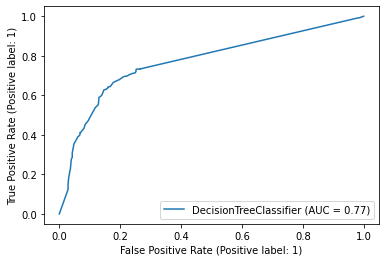

In [25]:
criterion = 'gini' #'{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 22, 'min_samples_leaf': 4, 'min_samples_split': 2}
# Train and test model
good_model_D = DecisionTreeClassifier(criterion=criterion,
                                    max_leaf_nodes=200) # create model 
print(good_model_D) # display model parameters
good_model_D.fit(X_train, y_train) # train model
pred_D = good_model_D.predict(X_test) # predicted output for test examples
print("Results on test data")
acc_D = accuracy_score(y_test, pred_D) # accuracy on test examples
prec_D = precision_score(y_test, pred_D) # precision on test examples
reca_D = recall_score(y_test, pred_D) # recall on test examples
print(f'Test accuracy = {acc_D: .4f}') # round to 4 decimal places
print(f'Test precision = {prec_D: .4f}') # round to 4 decimal places
print(f'Test recall = {reca_D: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, pred_D))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_D)))
print('\nROC curve')
plot_roc_curve(good_model_D, X_test, y_test)  # 
plt.show()

### Random Forest Model

In [26]:
modelR = RandomForestClassifier()
modelR.fit(X_train, y_train) 

RandomForestClassifier()

In [27]:
pred_train = modelR.predict(X_train)
pred_test=modelR.predict(X_test)
acc_train = accuracy_score(pred_train, y_train)
acc_test = accuracy_score(pred_test, y_test)
print(f'Training accuracy {acc_train: .3f}') 
print(f'Testing accuracy {acc_test: .3f}')

Training accuracy  0.990
Testing accuracy  0.780


In [28]:
tuned_parameters = [{'n_estimators': [50, 75,100],
                     'max_features': [15, 20, 25],
                     'max_leaf_nodes': [8, 16, 24]}] # hyperparameters to tune

clfR = GridSearchCV(RandomForestClassifier(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
clfR.fit(X_train, y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clfR.best_params_) # best hyperparameter values

print("\nGrid scores:")
means = clfR.cv_results_['mean_test_score'] # mean accuracy with folds
stds = clfR.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(means, stds, clfR.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters found:
{'max_features': 25, 'max_leaf_nodes': 24, 'n_estimators': 50}

Grid scores:
0.570 (+/-0.001) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 50}
0.571 (+/-0.003) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 75}
0.570 (+/-0.001) for {'max_features': 15, 'max_leaf_nodes': 8, 'n_estimators': 100}
0.582 (+/-0.005) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 50}
0.574 (+/-0.005) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 75}
0.574 (+/-0.007) for {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 100}
0.595 (+/-0.012) for {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 50}
0.597 (+/-0.013) for {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 75}
0.595 (+/-0.008) for {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 100}
0.571 (+/-0.002) for {'max_features': 20, 'max_leaf_nodes': 8, 'n_estimators': 50

### Model Results For Best Parameters (Random forest)

RandomForestClassifier(max_features=25, max_leaf_nodes=24, n_estimators=75)
Results on test data
Test accuracy =  0.6277
Test precision =  0.9888
Test recall =  0.1346
Classification report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.75       869
           1       0.99      0.13      0.24       654

    accuracy                           0.63      1523
   macro avg       0.80      0.57      0.50      1523
weighted avg       0.77      0.63      0.53      1523

Confusion matrix (Rows actual, Columns predicted):
     0   1
0  868   1
1  566  88

ROC curve


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


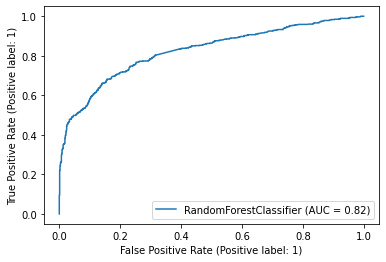

In [29]:
# Specify non-default hyper-parameter values
max_features = 25
max_leaf_nodes = 24
n_estimators = 75
# Train and test model
good_model = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes,
                                    max_features = max_features, 
                                    n_estimators=n_estimators, ) # create model 
print(good_model) # display model parameters
good_model.fit(X_train, y_train) # train model
pred = good_model.predict(X_test) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
prec = precision_score(y_test, pred) # precision on test examples
reca = recall_score(y_test, pred) # recall on test examples
print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {prec: .4f}') # round to 4 decimal places
print(f'Test recall = {reca: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, pred))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))
print('\nROC curve')
plot_roc_curve(good_model, X_test, y_test)  # 
plt.show()

### LOGISTIC REGRESSION

In [30]:
modelL=LogisticRegression()
modelL.fit(X_train,y_train)

LogisticRegression()

In [31]:
pred_trainL = modelL.predict(X_train)
pred_testL=modelL.predict(X_test)
acc_trainL = accuracy_score(pred_trainL, y_train)
acc_testL = accuracy_score(pred_testL, y_test)
print(f'Training accuracy {acc_trainL: .3f}') 
print(f'Testing accuracy {acc_testL: .3f}')

Training accuracy  0.890
Testing accuracy  0.796


In [32]:
tuned_parameters = [{'C': [10.0, 100.0, 1000.0, 10000.0],
                     'max_iter': [500, 1000]}] # hyperparameters to tune


clfL = GridSearchCV(LogisticRegression(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
clfL.fit(X_train,y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clfL.best_params_) # best hyperparameter values

print("\nGrid scores:")
meansL = clfL.cv_results_['mean_test_score'] # mean accuracy with folds
stdsL = clfL.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansL, stdsL, clfL.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found:
{'C': 10.0, 'max_iter': 500}

Grid scores:
0.788 (+/-0.020) for {'C': 10.0, 'max_iter': 500}
0.788 (+/-0.020) for {'C': 10.0, 'max_iter': 1000}
0.773 (+/-0.016) for {'C': 100.0, 'max_iter': 500}
0.773 (+/-0.016) for {'C': 100.0, 'max_iter': 1000}
0.764 (+/-0.020) for {'C': 1000.0, 'max_iter': 500}
0.764 (+/-0.020) for {'C': 1000.0, 'max_iter': 1000}
0.758 (+/-0.023) for {'C': 10000.0, 'max_iter': 500}
0.758 (+/-0.019) for {'C': 10000.0, 'max_iter': 1000}


### Model Results on Best Parameters (Logistic Reg)

LogisticRegression(C=1000, max_iter=1000)
Results on test data
Test accuracy =  0.7597
Test precision =  0.7257
Test recall =  0.7080
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       869
           1       0.73      0.71      0.72       654

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  694  175
1  191  463

ROC curve


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


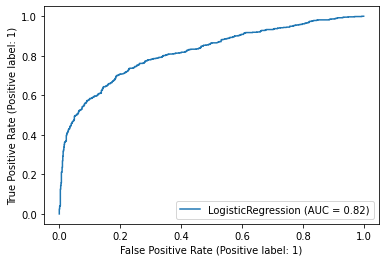

In [33]:
# Specify non-default hyper-parameter values
C = 1000
max_iter = 1000
# Train and test model
good_modelL = LogisticRegression(C = C, max_iter=max_iter) # create model 
print(good_modelL) # display model parameters
good_modelL.fit(X_train,y_train) # train model
predL = good_modelL.predict(X_test) # predicted output for test examples
print("Results on test data")
accL = accuracy_score(y_test, predL) # accuracy on test examples
precL = precision_score(y_test, predL) # precision on test examples
recaL = recall_score(y_test, predL) # recall on test examples
print(f'Test accuracy = {accL: .4f}') # round to 4 decimal places
print(f'Test precision = {precL: .4f}') # round to 4 decimal places
print(f'Test recall = {recaL: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, predL))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predL)))
print('\nROC curve')
plot_roc_curve(good_modelL, X_test, y_test)  # 
plt.show()

### KNN Model

In [34]:
modelknn= KNeighborsClassifier().fit(X_train,y_train)
pred_trainknn = modelknn.predict(X_train)
pred_testknn=modelknn.predict(X_test)
acc_trainknn = accuracy_score(pred_trainknn, y_train)
acc_testknn = accuracy_score(pred_testknn, y_test)
print(f'Training accuracy {acc_trainknn: .3f}') 
print(f'Testing accuracy {acc_testknn: .3f}')

Training accuracy  0.833
Testing accuracy  0.756


In [35]:
tuned_parameters = [{'algorithm':['brute'],
                     'metric': ['euclidean', 'minkowski'],
                    'n_neighbors': [5, 10, 20]}] # hyperparameters to tune

clfknn = GridSearchCV(KNeighborsClassifier(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
clfknn.fit(X_train, y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clfknn.best_params_) # best hyperparameter balues

print("\nGrid scores:")
meansknn = clfknn.cv_results_['mean_test_score'] # mean accuracy with folds
stdsknn = clfknn.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansknn, stdsknn, clfknn.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters found:
{'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 20}

Grid scores:
0.762 (+/-0.019) for {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 5}
0.769 (+/-0.013) for {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 10}
0.771 (+/-0.012) for {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 20}
0.762 (+/-0.019) for {'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 5}
0.769 (+/-0.013) for {'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 10}
0.771 (+/-0.012) for {'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 20}


### Model Results on Best Parameters (KNN)

KNeighborsClassifier(algorithm='brute', metric='euclidean')
Results on test data
Test accuracy =  0.7557
Test precision =  0.8422
Test recall =  0.5306
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       869
           1       0.84      0.53      0.65       654

    accuracy                           0.76      1523
   macro avg       0.78      0.73      0.73      1523
weighted avg       0.77      0.76      0.74      1523

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  804   65
1  307  347

ROC curve


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


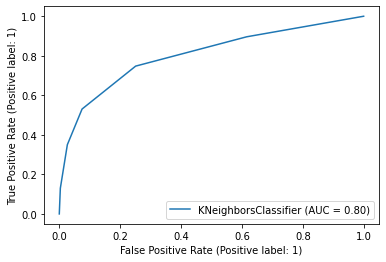

In [36]:
# Specify non-default hyper-parameter values
algorithm = 'brute'
metric = 'euclidean'
n_neighbors =  5
# Train and test model
good_modelknn = KNeighborsClassifier(algorithm=algorithm, metric=metric, 
                                  n_neighbors=n_neighbors) # create model 
print(good_modelknn) # display model parameters
good_modelknn.fit(X_train, y_train) # train model
predknn = good_modelknn.predict(X_test) # predicted output for test examples
print("Results on test data")
accknn = accuracy_score(y_test, predknn) # accuracy on test examples
precknn = precision_score(y_test, predknn) # precision on test examples
recaknn = recall_score(y_test, predknn) # recall on test examples
print(f'Test accuracy = {accknn: .4f}') # round to 4 decimal places
print(f'Test precision = {precknn: .4f}') # round to 4 decimal places
print(f'Test recall = {recaknn: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, predknn))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predknn)))
print('\nROC curve')
plot_roc_curve(good_modelknn, X_test, y_test)  # 
plt.show()

### SVM 

In [37]:
modelsvm=svm.SVC().fit(X_train,y_train)
pred_trainsvm = modelsvm.predict(X_train)
pred_testsvm=modelsvm.predict(X_test)
acc_trainsvm = accuracy_score(pred_trainsvm, y_train)
acc_testsvm = accuracy_score(pred_testsvm, y_test)
print(f'Training accuracy {acc_trainsvm: .3f}') 
print(f'Testing accuracy {acc_testsvm: .3f}')

Training accuracy  0.969
Testing accuracy  0.798


In [38]:
tuned_parameters = [{'kernel':['rbf'], 'gamma':[0.1,1], 'C':[1,2,3]}]
                     # hyperparameters to tune

clfsvm = GridSearchCV(svm.SVC(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
clfsvm.fit(X_train,y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clfsvm.best_params_) # best hyperparameter balues

print("\nGrid scores:")
meansvm = clfsvm.cv_results_['mean_test_score'] # mean accuracy with folds
stdsvm = clfsvm.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansvm, stdsvm, clfsvm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters found:
{'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores:
0.735 (+/-0.014) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.793 (+/-0.010) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.789 (+/-0.011) for {'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.794 (+/-0.011) for {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
0.796 (+/-0.006) for {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}
0.793 (+/-0.017) for {'C': 3, 'gamma': 1, 'kernel': 'rbf'}


### Model Results on Best Parameters (SVM)

SVC(C=1, gamma=1)
Results on test data
Test accuracy =  0.7984
Test precision =  0.8463
Test recall =  0.6483
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       869
           1       0.85      0.65      0.73       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  792   77
1  230  424

ROC curve


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


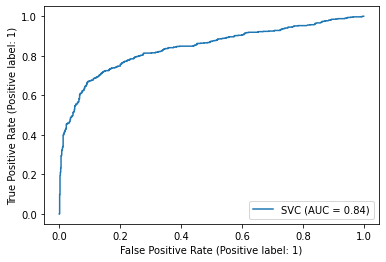

In [39]:
# Specify non-default hyper-parameter values
C = 1 # algorithm name
kernel = 'rbf'# kernel type
gamma =  1 # kernel parameter
# Train and test model
good_modelsvm = svm.SVC(C=C, kernel=kernel, 
                                  gamma=gamma) # create model 
print(good_modelsvm) # display model parameters
good_modelsvm.fit(X_train,y_train) # train model
predsvm = good_modelsvm.predict(X_test) # predicted output for test examples
print("Results on test data")
accsvm = accuracy_score(y_test, predsvm) # accuracy on test examples
precsvm = precision_score(y_test, predsvm) # precision on test examples
recasvm = recall_score(y_test, predsvm) # recall on test examples
print(f'Test accuracy = {accsvm: .4f}') # round to 4 decimal places
print(f'Test precision = {precsvm: .4f}') # round to 4 decimal places
print(f'Test recall = {recasvm: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, predsvm))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predsvm)))
print('\nROC curve')
plot_roc_curve(good_modelsvm, X_test, y_test)  # 
plt.show()

### XG BOOST

In [40]:
tuned_parameters_xgb=[{'booster':['gbtree'], 'objective':['binary:logistic'], 'eta':[0.1,0.2], 'max_depth':[5], 'subsample':[0.7,0.6],
                       'colsample_bytree':[0.6,0.5], 'colsample_bylevel':[0.9,1], 'colsample_bynode':[0.8], 'alpha':[0.2], 'lambda':[0.3,0.4],
                       'n_estimators':[200,250]}]
clfxgb = GridSearchCV(XGBClassifier(), tuned_parameters_xgb, verbose=1, n_jobs=-1) # grid search model
clfxgb.fit(X_train, y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clfxgb.best_params_) # best hyperparameter balues

print("\nGrid scores:")
meansknn = clfxgb.cv_results_['mean_test_score'] # mean accuracy with folds
stdsknn = clfxgb.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansknn, stdsknn, clfxgb.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters found:
{'alpha': 0.2, 'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'eta': 0.2, 'lambda': 0.3, 'max_depth': 5, 'n_estimators': 250, 'objective': 'binary:logistic', 'subsample': 0.7}

Grid scores:
0.767 (+/-0.016) for {'alpha': 0.2, 'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'eta': 0.1, 'lambda': 0.3, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.7}
0.767 (+/-0.014) for {'alpha': 0.2, 'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'eta': 0.1, 'lambda': 0.3, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.6}
0.771 (+/-0.015) for {'alpha': 0.2, 'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'eta': 0.1, 'lambda': 0.3, 'max_depth': 5, 'n_e

XGBClassifier(alpha=0.2, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=0.8, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Results on test data
Test accuracy =  0.7446
Test precision =  0.8046
Test recall =  0.5352
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       869
           1       0.80      0.54      0.64       654

    accurac

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


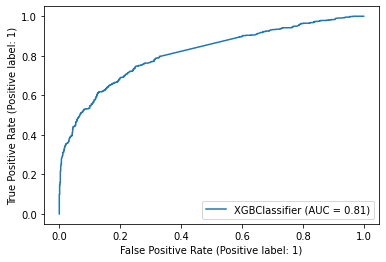

In [41]:
good_modelxgb= XGBClassifier(booster='gbtree', objective='binary:logistic', eta=0.1, max_depth=5, subsample=0.7,colsample_bytree=0.6, colsample_bylevel=0.9, colsample_bynode=0.8,
                             alpha=0.2, reg_lambda= 0.3, n_estimators=200, random_state=42, verbosity=1) # create model 
print(good_modelxgb) # display model parameters
good_modelxgb.fit(X_train,y_train) # train model
predxgb = good_modelxgb.predict(X_test) # predicted output for test examples
print("Results on test data")
accsvm = accuracy_score(y_test, predxgb) # accuracy on test examples
precsvm = precision_score(y_test, predxgb) # precision on test examples
recasvm = recall_score(y_test, predxgb) # recall on test examples
print(f'Test accuracy = {accsvm: .4f}') # round to 4 decimal places
print(f'Test precision = {precsvm: .4f}') # round to 4 decimal places
print(f'Test recall = {recasvm: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, predxgb))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predxgb)))
print('\nROC curve')
plot_roc_curve(good_modelxgb, X_test, y_test)  # 
plt.show()

### NAIVE BAYES

In [42]:
tuned_parameters = [{'alpha': [0.1, 1, 10],
              'fit_prior': [True, False],
              'class_prior': [None, [0.3,0.7], [0.5,0.5]]}]
                     # hyperparameters to tune

clfnb = GridSearchCV(MultinomialNB(), tuned_parameters, 
                   verbose=1, n_jobs=-1) # grid search model
clfnb.fit(X_train,y_train) # evaluate hyper-parameters

print("\nBest parameters found:")
print(clfnb.best_params_) # best hyperparameter balues

print("\nGrid scores:")
meansvm = clfnb.cv_results_['mean_test_score'] # mean accuracy with folds
stdsvm = clfnb.cv_results_['std_test_score'] # standard deviation of accuracies
# for each hyperparameter combination show mean +/- 2 standard-deviations 
for mean, std, params in zip(meansvm, stdsvm, clfsvm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" %(mean, std * 2, params)) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters found:
{'alpha': 1, 'class_prior': None, 'fit_prior': True}

Grid scores:
0.784 (+/-0.010) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.765 (+/-0.011) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.680 (+/-0.021) for {'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.680 (+/-0.021) for {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
0.765 (+/-0.011) for {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}
0.765 (+/-0.011) for {'C': 3, 'gamma': 1, 'kernel': 'rbf'}


MultinomialNB(alpha=0.1)
Results on test data
Test accuracy =  0.7774
Test precision =  0.7730
Test recall =  0.6820
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       869
           1       0.77      0.68      0.72       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  738  131
1  208  446

ROC curve


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


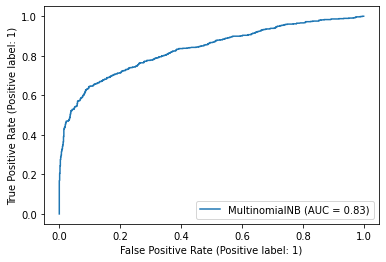

In [43]:
good_modelnb= MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
                              # create model 
print(good_modelnb) # display model parameters
good_modelnb.fit(X_train,y_train) # train model
prednb = good_modelnb.predict(X_test) # predicted output for test examples
print("Results on test data")
accnb = accuracy_score(y_test, prednb) # accuracy on test examples
precnb = precision_score(y_test, prednb) # precision on test examples
recanb = recall_score(y_test, prednb) # recall on test examples
print(f'Test accuracy = {accnb: .4f}') # round to 4 decimal places
print(f'Test precision = {precnb: .4f}') # round to 4 decimal places
print(f'Test recall = {recanb: .4f}') # round to 4 decimal places
print("Classification report:")
print(classification_report(y_test, prednb))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, prednb)))
print('\nROC curve')
plot_roc_curve(good_modelnb, X_test, y_test)  # 
plt.show()

# GETTING COMBINED RESULTS OF MODELS AFTER FINIDING BEST HYPERPARAMETERS

In [44]:
models_tuned = []

models_tuned.append(('Logistic Regression', LogisticRegression(solver='liblinear',C = 10, max_iter=500, random_state = 0)))
models_tuned.append(('SVC', SVC(C=1, kernel = 'linear', gamma=1, random_state = 0)))
models_tuned.append(('Kernel SVM', SVC(C=1, kernel = 'rbf', gamma=1, random_state = 0)))
models_tuned.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', p = 2,algorithm='brute')))
models_tuned.append(('Multinomial NB', good_modelnb))
models_tuned.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes=19, random_state = 0)))
models_tuned.append(('Random Forest', RandomForestClassifier(max_leaf_nodes = 24,max_features = 25, 
                                                           n_estimators = 50,criterion = 'entropy', random_state = 0)))
models_tuned.append(('XBGClassifer',XGBClassifier(booster='gbtree', objective='binary:logistic', eta=0.1, max_depth=5, subsample=0.8,colsample_bytree=0.7, colsample_bylevel=0.8, colsample_bynode=0.8,
                             alpha=0.2, reg_lambda= 0.2, n_estimators=150, random_state=42, verbosity=1)))

In [45]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, model in models_tuned:
    names_opt.append(name)
    kfold = model_selection.KFold(n_splits=10)
    
    cv_acc_results_opt = model_selection.cross_val_score(model, X_train, y_train, 
                    cv = kfold, scoring="accuracy")
    cv_auc_results_opt = model_selection.cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="roc_auc")
    cv_pre_results_opt = model_selection.cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="precision")
    cv_f1_results_opt = model_selection.cross_val_score(model, X_train, y_train,
                    cv = kfold, scoring="f1")
    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    model_results_opt.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,Algorithm,ROC AUC,Accuracy,Precision,F1 Scores
2,Kernel SVM,85.58,79.75,87.63,72.24
1,SVC,85.31,79.70,82.18,73.96
0,Logistic Regression,84.96,79.16,79.88,73.82
4,Multinomial NB,84.41,77.82,75.26,73.54
7,XBGClassifer,82.61,75.99,83.51,66.18
6,Random Forest,81.33,62.86,98.89,24.10
3,KNN,80.65,76.40,82.67,67.44
5,Decision Tree Classifier,64.31,68.46,85.05,46.68


# MODEL RESULTS ON TEST DATA FOR BEST USED HYPERPARAMETERS

In [46]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, model in models_tuned:
    names_opt.append(name)
    kfold = model_selection.KFold(n_splits=10)
    
    cv_acc_results_opt = model_selection.cross_val_score(model, X_test, y_test, 
                    cv = kfold, scoring="accuracy")
    cv_auc_results_opt = model_selection.cross_val_score(model, X_test, y_test,
                    cv = kfold, scoring="roc_auc")
    cv_pre_results_opt = model_selection.cross_val_score(model, X_test, y_test,
                    cv = kfold, scoring="precision")
    cv_f1_results_opt = model_selection.cross_val_score(model, X_test, y_test,
                    cv = kfold, scoring="f1")
    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    model_results_opt.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1
model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,F1 Scores
2,Kernel SVM,80.67,73.54,84.73,60.10
1,SVC,80.50,75.63,78.48,67.97
0,Logistic Regression,79.52,74.71,75.27,67.75
4,Multinomial NB,79.34,74.71,73.65,68.93
6,Random Forest,76.32,60.47,98.75,15.05
7,XBGClassifer,76.27,70.92,75.03,58.97
5,Decision Tree Classifier,61.53,65.79,77.95,41.26
3,KNN,59.01,59.55,100.00,11.02


In [47]:
#Preprocessing the text column
data_test['clean_text']=data_test['text'].apply(text_cleaner)
data_test['clean_text'] = data_test['clean_text'].apply(lambda x: nlp(x))
data_test['final_text']=data_test['clean_text'].apply(preprocess)

In [48]:
#tfidf=TfidfVectorizer(use_idf=False)

In [49]:
eval=vectorizer.transform(data_test['final_text']).toarray()

In [50]:
final_pred = good_modelsvm.predict(eval)

In [51]:
submission2 = data_test[['id']].reset_index(drop=True)
submission2['target'] = final_pred.astype('int64')

In [52]:
submission2

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [53]:
submission2.to_csv('submission.csv', index=False)